2025-05-16 19:20:25.097804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747423225.298519      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747423225.354537      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2152 images belonging to 3 classes.

Chargement du modèle MobileNetV2...


I0000 00:00:1747423261.029303      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Résumé du modèle MobileNetV2 (extrait) :
Nombre total de couches : 155
Nombre total de paramètres : 2,257,984
Couche utilisée pour les feature maps : 'block_3_depthwise'


I0000 00:00:1747423268.466178      64 service.cc:148] XLA service 0x7dbdd8110b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747423268.466958      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747423268.996174      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

I0000 00:00:1747423272.329263      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step

 Temps total d'entraînement + extraction des features : 23.76 secondes

Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.99      0.99      0.99       200
 Potato___Late_blight       0.99      0.99      0.99       200
     Potato___healthy       1.00      0.94      0.97        31

             accuracy                           0.99       431
            macro avg       0.99      0.97      0.98       431
         weighted avg       0.99      0.99      0.99       431


 Accuracy (précision globale sur les données de test) : 98.84 %


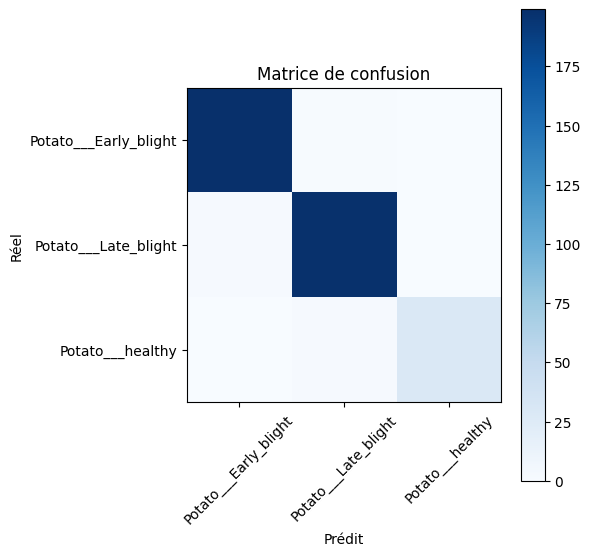

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


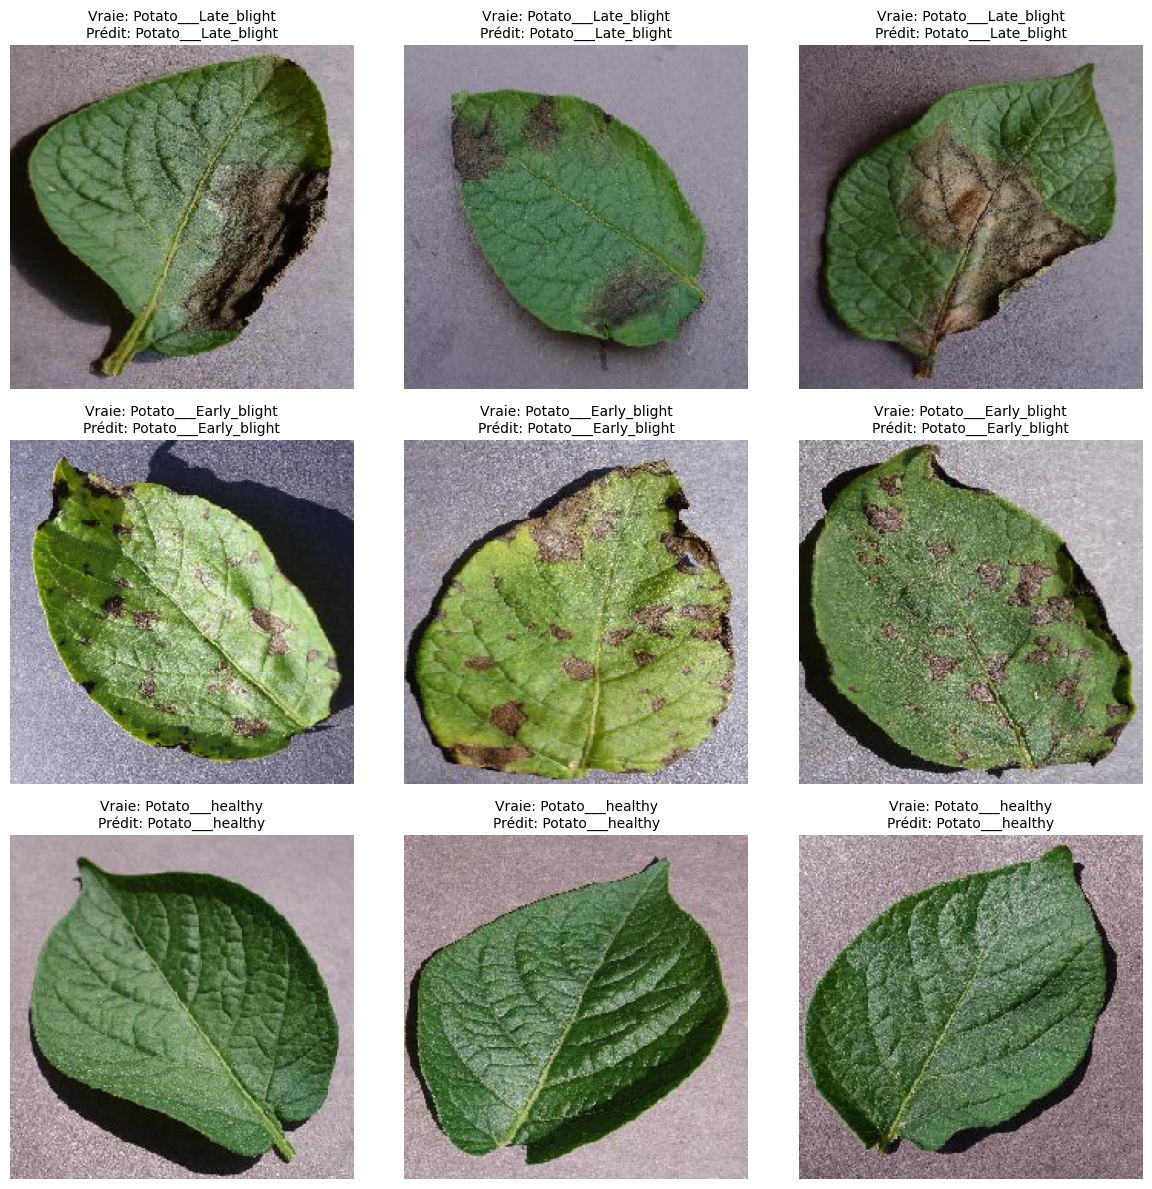


 Visualisation des feature maps de la couche : block_3_depthwise
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


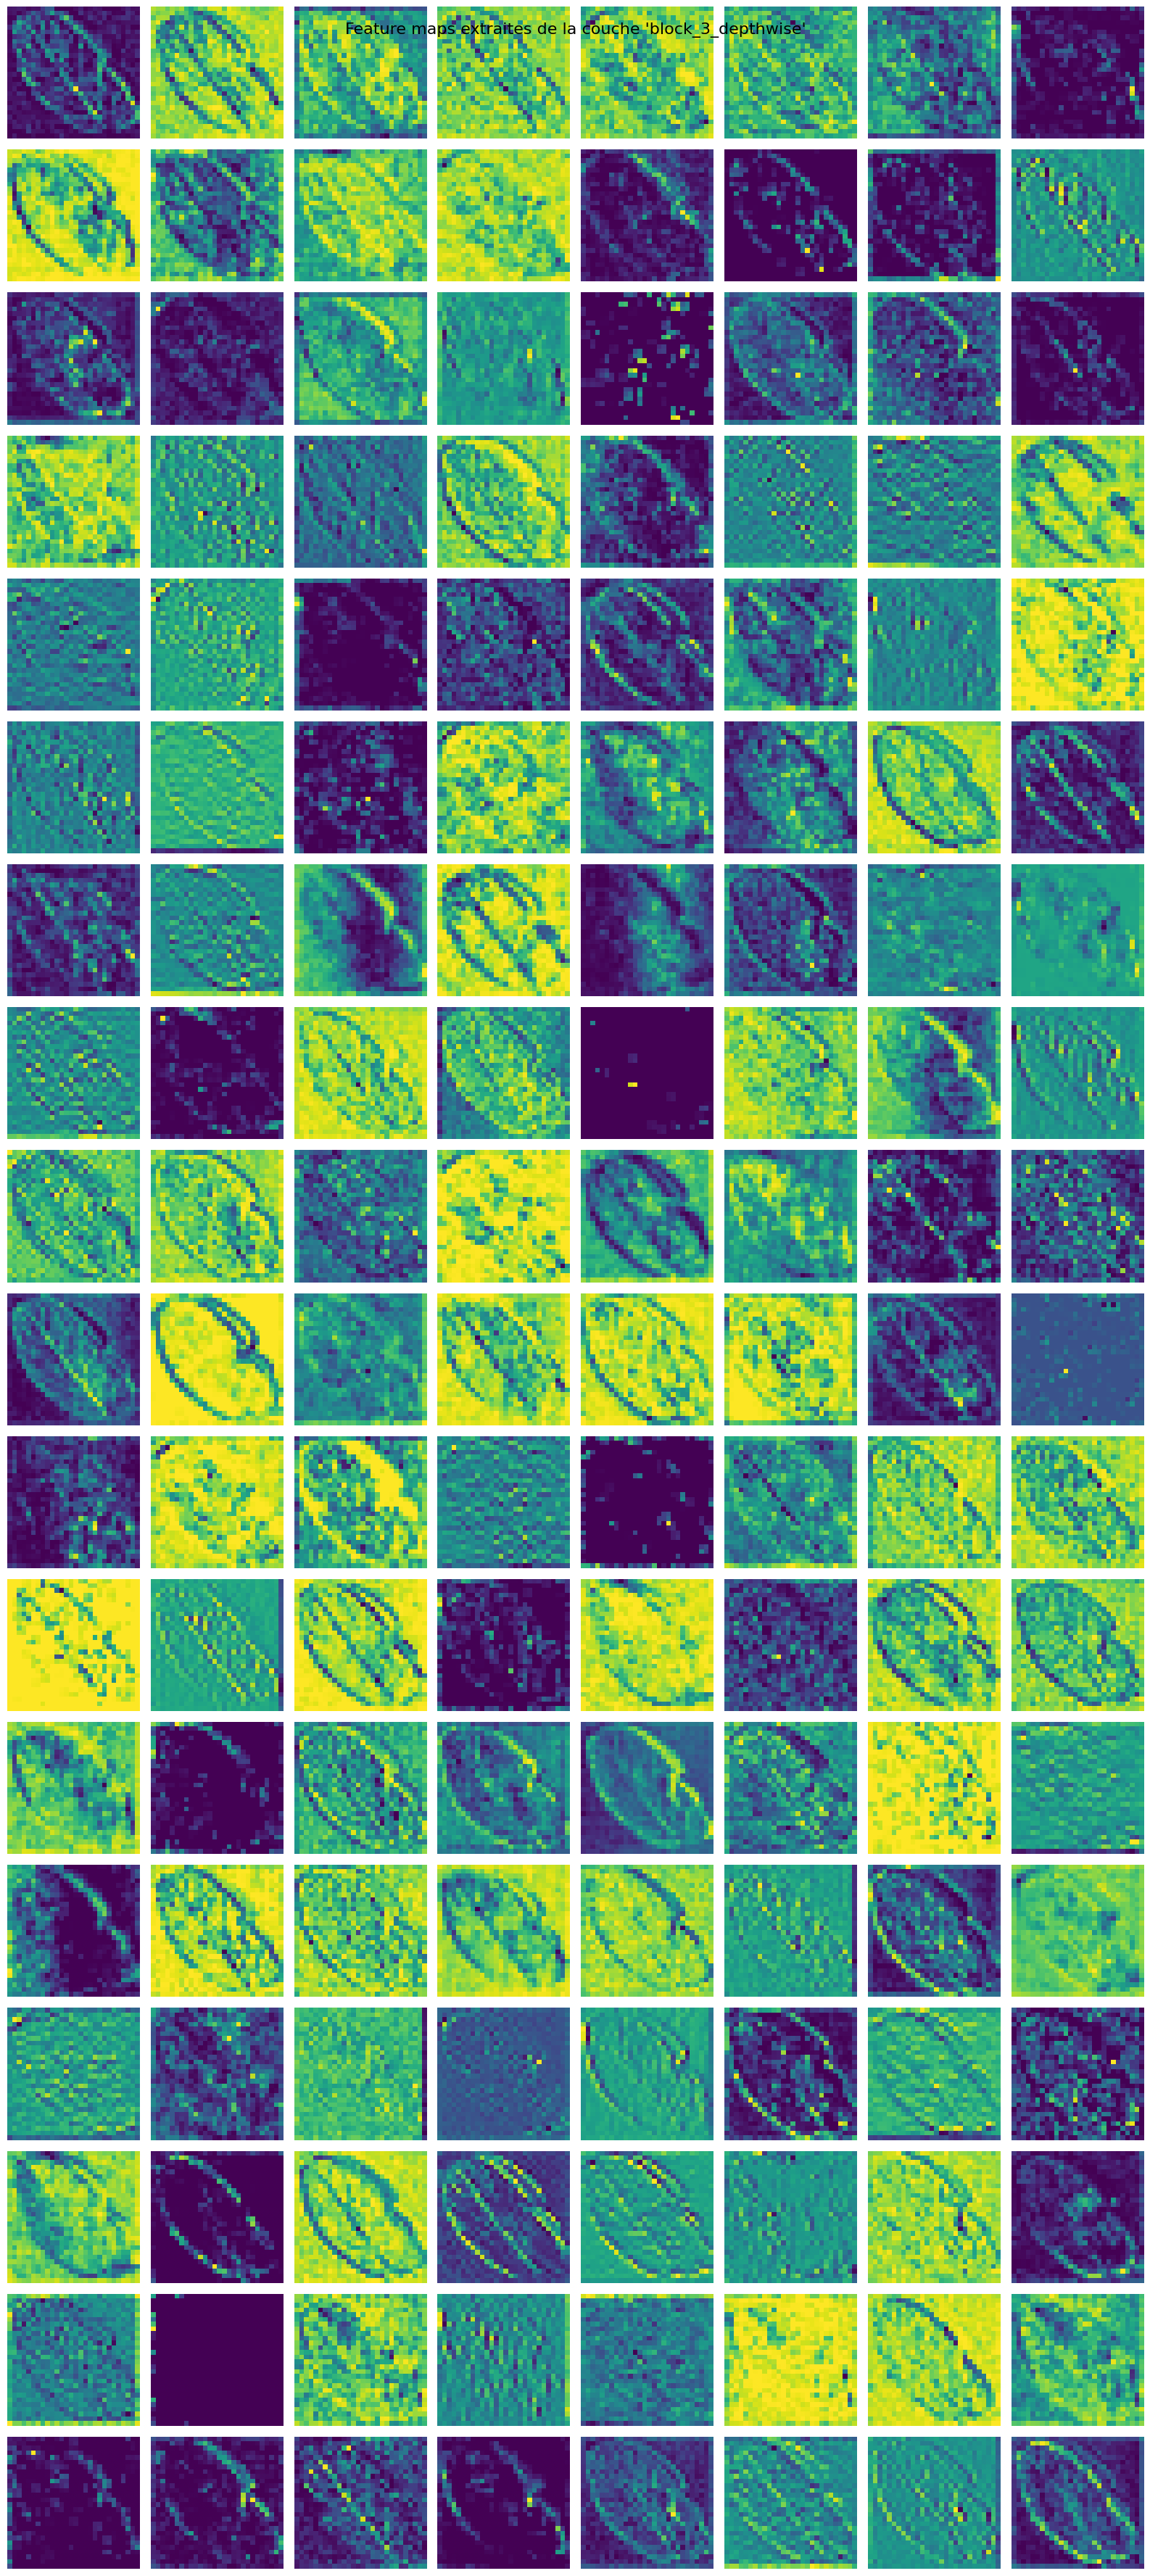

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import random
import time
from tensorflow.keras.models import Model
# Paramètres
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "/kaggle/input/potato/potato"
SEED = 42

# Chargement des images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=SEED
)

class_names = list(generator.class_indices.keys())
num_classes = len(class_names)

# Récupérer toutes les données
X = []
y = []
for i in range(len(generator)):
    images, labels = generator[i]
    X.append(images)
    y.append(labels)
    if (i + 1) * BATCH_SIZE >= generator.n:
        break

X = np.concatenate(X)
y = np.concatenate(y)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Extraction des caractéristiques avec MobileNetV2
print("\nChargement du modèle MobileNetV2...")
start_time = time.time()
base_model = MobileNetV2(include_top=False, pooling='avg', input_shape=IMAGE_SIZE + (3,), weights='imagenet')

# Résumé condensé du modèle
print("\nRésumé du modèle MobileNetV2 (extrait) :")
print(f"Nombre total de couches : {len(base_model.layers)}")
print(f"Nombre total de paramètres : {base_model.count_params():,}")
print("Couche utilisée pour les feature maps : 'block_3_depthwise'")

X_train_features = base_model.predict(X_train, verbose=1)
X_test_features = base_model.predict(X_test, verbose=1)

# Entraînement SVM
svm = SVC(kernel='linear', probability=True, random_state=SEED)
svm.fit(X_train_features, y_train)
runtime = time.time() - start_time
print(f"\n Temps total d'entraînement + extraction des features : {runtime:.2f} secondes")

# Évaluation
y_pred = svm.predict(X_test_features)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Accuracy
accuracy = np.mean(y_pred == y_test)
print(f"\n Accuracy (précision globale sur les données de test) : {accuracy * 100:.2f} %")

# Matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues')
plt.title("Matrice de confusion")
plt.xticks(ticks=np.arange(num_classes), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(num_classes), labels=class_names)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()
plt.tight_layout()
plt.show()

# Fonction : afficher des prédictions aléatoires depuis le jeu de test
def predict_some_test_images_grid(num_images=9):
    shown_classes = defaultdict(int)
    max_per_class = max(1, num_images // len(class_names))
    shown_total = 0

    indices = list(range(len(X_test)))
    random.shuffle(indices)

    selected_images = []

    for idx in indices:
        if shown_total >= num_images:
            break

        img_array = X_test[idx]
        true_label = y_test[idx]
        true_class = class_names[int(true_label)]

        if shown_classes[true_class] >= max_per_class:
            continue

        img_input = np.expand_dims(img_array, axis=0)
        features = base_model.predict(img_input)

        prediction = svm.predict(features)[0]
        predicted_class = class_names[int(prediction)]

        selected_images.append(((img_array + 1) / 2, true_class, predicted_class))
        shown_classes[true_class] += 1
        shown_total += 1

    # === Affichage ===
    cols = 3
    rows = (len(selected_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.atleast_2d(axes)

    for i, (img, true_class, pred_class) in enumerate(selected_images):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(img)
        ax.set_title(f"Vraie: {true_class}\nPrédit: {pred_class}", fontsize=10)
        ax.axis('off')

    for j in range(len(selected_images), rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# Fonction : prédiction d’images personnalisées
def predict_images_in_folder(folder_path):
    image_paths = [os.path.join(folder_path, fname)
                   for fname in os.listdir(folder_path)
                   if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_paths:
        print("Aucune image trouvée.")
        return

    for img_path in image_paths:
        try:
            img = load_img(img_path, target_size=IMAGE_SIZE)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            features = base_model.predict(img_array)
            prediction = svm.predict(features)[0]
            predicted_class = class_names[int(prediction)]

            confidence = svm.decision_function(features)
            confidence_score = np.max(confidence) if confidence.ndim == 1 else np.max(confidence[0])

            plt.imshow(load_img(img_path))
            plt.title(f"{os.path.basename(img_path)}\nPrédit : {predicted_class}\nConfiance : {confidence_score:.2f}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Erreur avec {img_path} : {e}")

# Exemple d’utilisation
predict_some_test_images_grid(num_images=9)
# predict_images_in_folder("/kaggle/input/potatotestdataperso/testdata")  # Décommente si besoin
# === Visualisation des feature maps pour une image aléatoire du test set ===


def display_feature_maps(layer_name='block_3_depthwise'):
    print(f"\n Visualisation des feature maps de la couche : {layer_name}")

    # Sélection d'une image aléatoire du test set
    idx = np.random.randint(0, len(X_test))
    test_image = X_test[idx]
    image_batch = np.expand_dims(test_image, axis=0)

    # Création du modèle intermédiaire jusqu'à la couche choisie
    intermediate_layer_model = Model(inputs=base_model.input,
                                     outputs=base_model.get_layer(layer_name).output)

    # Prédiction (extraction des feature maps)
    feature_maps = intermediate_layer_model.predict(image_batch)

    # Dimensions des feature maps
    num_feature_maps = feature_maps.shape[-1]

    # Nombre de lignes et colonnes pour afficher plusieurs cartes
    n_cols = 8
    n_rows = num_feature_maps // n_cols
    if num_feature_maps % n_cols != 0:
        n_rows += 1

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(num_feature_maps):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature maps extraites de la couche '{layer_name}'", fontsize=16)
    plt.tight_layout()
    plt.show()

# Affichage des feature maps
display_feature_maps('block_3_depthwise')
